<a href="https://colab.research.google.com/github/shojaeinia/shojaeinia/blob/main/TED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


What is ResNet50

In general, in a deep convolutional neural network, several layers are stacked and are trained to the task at hand. The network learns several low/mid/high level features at the end of its layers. In residual learning, instead of trying to learn some features, we try to learn some residual. Residual can be simply understood as subtraction of feature learned from input of that layer. ResNet does this using shortcut connections (directly connecting input of nth layer to some (n+x)th layer. It has proved that training this form of networks is easier than training simple deep convolutional neural networks and also the problem of degrading accuracy is resolved.

This is the fundamental concept of ResNet.

ResNet50 is a 50 layer Residual Network. There are other variants like ResNet101 and ResNet152 also.


In [1]:
# Importing all necessary libraries
import os
import os.path
from skimage import io
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from keras.optimizers import Adam,RMSprop
from keras.losses import BinaryCrossentropy
from keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import imgaug.augmenters as iaa
import tensorflow.keras as keras

In [2]:
# Mounting Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_path = "/content/drive/MyDrive/Farabi_split/train"
val_path = "/content/drive/MyDrive/Farabi_split/val"
test_path = "/content/drive/MyDrive/Farabi_split/test"

In [4]:
path1 = train_path + "/Normal"
path2 = train_path + "/TED"

In [5]:
Normal=os.listdir(path1)
TED=os.listdir(path2)
print("number of normal images:", len(Normal))
print("number of TED images:", len(TED))

number of normal images: 299
number of TED images: 307


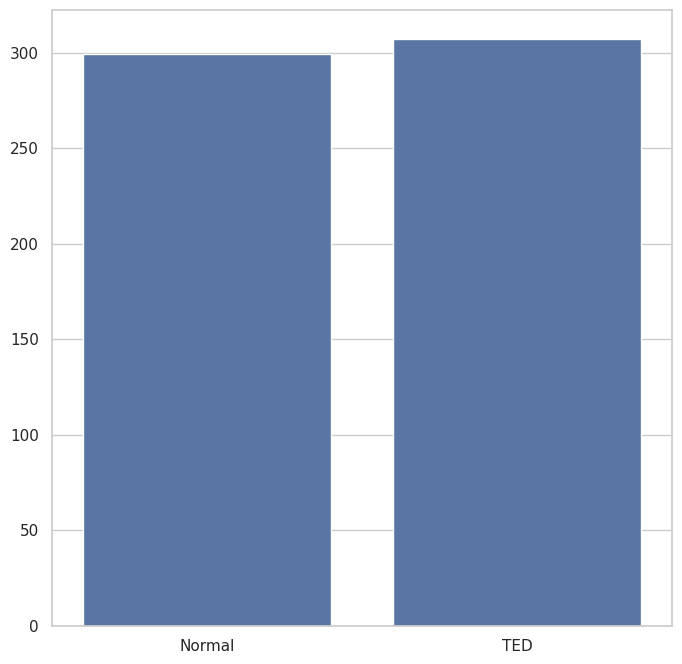

In [6]:
CATEGORIES = ["Normal", "TED"]
sns.set_theme(style="whitegrid")
plt.figure(figsize = (8,8))
ax = sns.barplot(x = CATEGORIES, y = [len(Normal),len(TED)])

In [7]:
!pip install imgaug

In [8]:
def load_batch(batch_idx):
    # dummy function, implement this
    # Return a numpy array of shape (N, height, width, #channels)
    # or a list of (height, width, #channels) arrays (may have different image
    # sizes).
    # Images should be in RGB for colorspace augmentations.
    # (cv2.imread() returns BGR!)
    # Images should usually be in uint8 with values from 0-255.
    return np.zeros((128, 32, 32, 3), dtype=np.uint8) + (batch_idx % 255)

def train_on_images(ax):
    # dummy function, implement this
    pass

# Pipeline:
# (1) Crop images from each side by 1-16px, do not resize the results
#     images back to the input size. Keep them at the cropped size.
# (2) Horizontally flip 50% of the images.
# (3) Blur images using a gaussian kernel with sigma between 0.0 and 3.0.
seq = iaa.Sequential([
    iaa.Crop(px=(1, 16), keep_size=False),
    iaa.Fliplr(0.5),
    iaa.GaussianBlur(sigma=(0, 3.0))
])

for batch_idx in range(100):
    images = load_batch(batch_idx)
    images_aug = seq(images=images)  # done by the library
    train_on_images(images_aug)

In [9]:
#Data Augmentation
train_val_generator = ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.3)
test_generator = ImageDataGenerator(rescale=1./255)

In [10]:
train = train_val_generator.flow_from_directory(train_path,
                                               batch_size=64,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

Found 606 images belonging to 2 classes.


In [11]:
val = train_val_generator.flow_from_directory(val_path,
                                               batch_size=16,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 172 images belonging to 2 classes.


In [12]:
test = test_generator.flow_from_directory(test_path,
                                          batch_size=32,
                                          target_size=(220,220),
                                          color_mode="rgb",
                                          class_mode="binary")

Found 89 images belonging to 2 classes.


In [13]:
#Deep Residual Network (ResNet)
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

94668760/94668760 [==============================] - 1s 0us/step


In [14]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False

model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))

In [15]:
#Compiling the Model
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36410113 (138.89 MB)
Trainable params: 12845313 (49.00 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


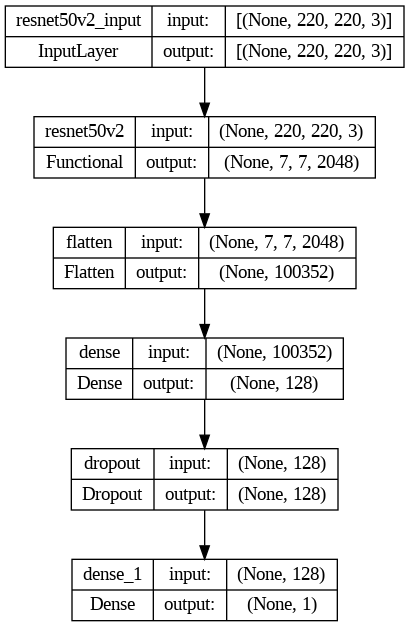

In [17]:
tf.keras.utils.plot_model(
    model, to_file='model1.png', show_layer_names=True, show_shapes=True)

In [18]:
hist = model.fit(train,validation_data=val,epochs=30)

Epoch 1/30
10/10 [==============================] - 327s 32s/step - loss: 7.2063 - accuracy: 0.6568 - val_loss: 3.9339 - val_accuracy: 0.6744
Epoch 2/30
10/10 [==============================] - 40s 4s/step - loss: 2.0959 - accuracy: 0.7426 - val_loss: 1.2068 - val_accuracy: 0.7093
Epoch 3/30
10/10 [==============================] - 39s 4s/step - loss: 0.8459 - accuracy: 0.7261 - val_loss: 0.5669 - val_accuracy: 0.8198
Epoch 4/30
10/10 [==============================] - 41s 4s/step - loss: 0.4549 - accuracy: 0.8135 - val_loss: 0.4629 - val_accuracy: 0.8198
Epoch 5/30
10/10 [==============================] - 40s 4s/step - loss: 0.3569 - accuracy: 0.8366 - val_loss: 0.4079 - val_accuracy: 0.8488
Epoch 6/30
10/10 [==============================] - 38s 4s/step - loss: 0.3477 - accuracy: 0.8630 - val_loss: 0.3652 - val_accuracy: 0.8198
Epoch 7/30
10/10 [==============================] - 39s 4s/step - loss: 0.3183 - accuracy: 0.8647 - val_loss: 0.3991 - val_accuracy: 0.8488
Epoch 8/30
10/10 [

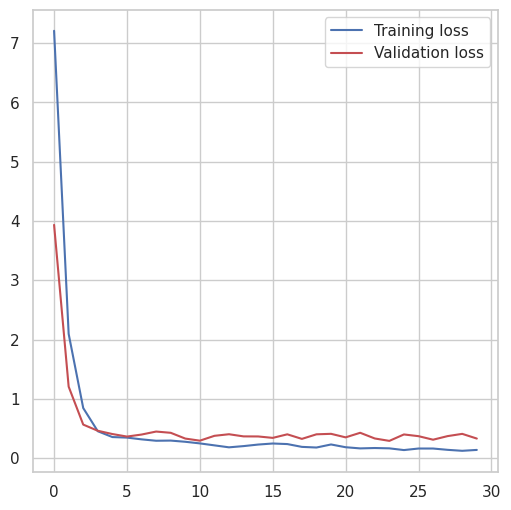

<Figure size 640x480 with 0 Axes>

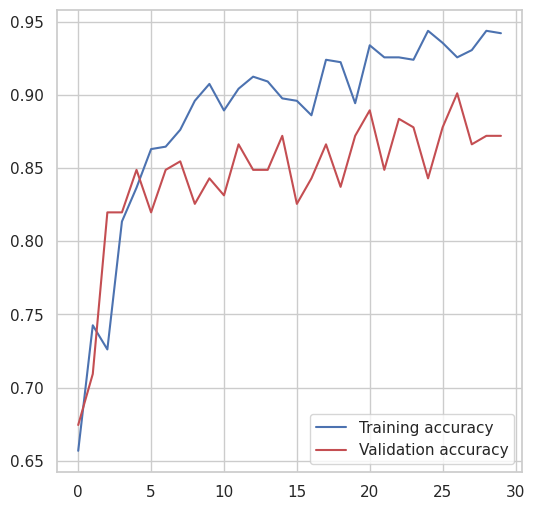

In [19]:
#Evaluate the Model
plt.figure(figsize=(6,6))
plt.plot(hist.history['loss'], color='b', label="Training loss")
plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(6,6))
plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend(loc = "lower right")
plt.show()

In [20]:
test_results = model.evaluate(test)

3/3 [==============================] - 27s 12s/step - loss: 0.1671 - accuracy: 0.9438


In [29]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [21]:
model.save('/content/drive/MyDrive/TED_Model_30Epoches')

In [31]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from google.colab import files

In [32]:
uploaded = files.upload()

Saving TED_1.jpg to TED_1.jpg


In [36]:
for fn in uploaded.keys():
  print('user uploaded file "{name}" with length {length} bytes'.format(name = fn, length = len(uploaded[fn])))

user uploaded file "TED_1.jpg" with length 17195 bytes


In [40]:
#model = load_model('/content/drive/MyDrive/TED_Model/saved_model.pb')
test_img_path = '/content/TED_1.jpg'
img = tf.keras.utils.load_img(
    test_img_path, target_size=(220, 220)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
result = model.predict(img_array)
score = tf.nn.softmax(result)
print("This image most likely belongs to {} with a {:.2f} percent confidence."
     .format(CATEGORIES[np.argmax(score)], 100 * np.max(score)))

#print (result)

1/1 [==============================] - 0s 27ms/step
This image most likely belongs to Normal with a 100.00 percent confidence.
